# 1. Setup

## 1.1. Install Dependencies

In [1]:
# Install tensorflow link for reference: https://www.tensorflow.org/install/pip

# Create the virtual environment
# conda create --name Name python=3.9

# Activate the virtual environment
# conda activate Name

# Install CUDA and cuDNN
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# pip install --upgrade pip

# Install packages from requirements.txt
# pip install -r requirements.txt

# Check for GPU devices
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

## 1.2. Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input
import tensorflow as tf

## 1.3. Set GPU Growth

In [4]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf

# Initialize a session to list devices
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

# Filter out GPU devices and print them
gpus = [device for device in devices if device.device_type == 'GPU']
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

GPUs available:
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18420375106705372951
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:10:00.0, compute capability: 8.6"
xla_global_id: 416903419



In [6]:
# Avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
len(gpus)

1

In [8]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.4. Create Folder Structure

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
POS_PATH

'data\\positive'

In [11]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1. Untar Labelled Faces in the Wild Dataset

In [11]:
# http://vis-www.cs.umass.edu/lfw
# Access website above to download `All images as gzipped tar file`
# Place file `lfw.tgz` in the working directory

In [12]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2. Collecte Positive and Anchor Classes

In [14]:
# Import uuid library to generate unique image names
import uuid

In [15]:
# Establish a connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250 x 250 px
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release webcam
cap.release()
# Close image show frame
cv2.destroyAllWindows()

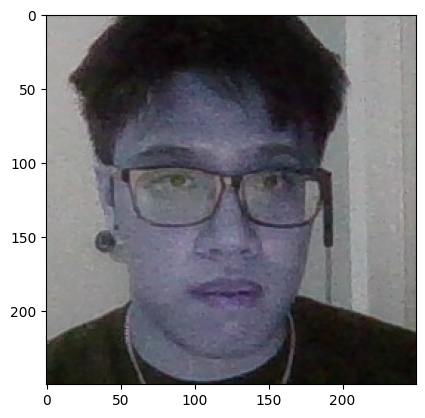

In [16]:
plt.imshow(frame)

## 2.3. Data Augmentation

In [17]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [18]:
img_path = os.path.join(ANC_PATH, 'c6cb3226-1c6c-11ef-ae38-845cf3d6a57d.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1. Get Image Directories

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(3000)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
dir_test.next()

b'data\\anchor\\b837a4c7-1e1f-11ef-b21d-845cf3d6a57d.jpg'

## 3.2.Preprocessing - Scale and Resize

In [14]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    return img

In [15]:
preprocess('data\\anchor\\d04f55a0-1c6c-11ef-95b1-845cf3d6a57d.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7414216 , 0.7610294 , 0.74534315],
        [0.7372549 , 0.75686276, 0.7411765 ],
        [0.7355392 , 0.75514704, 0.73946077],
        ...,
        [0.6894608 , 0.69730395, 0.6855392 ],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.67156863, 0.67941177, 0.6598039 ]],

       [[0.7372549 , 0.7558824 , 0.74313724],
        [0.73333335, 0.7522059 , 0.7387255 ],
        [0.7355392 , 0.75514704, 0.73946077],
        ...,
        [0.68602943, 0.6938726 , 0.68210787],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.672549  , 0.68039215, 0.66862744]],

       [[0.7372549 , 0.7529412 , 0.7490196 ],
        [0.73259807, 0.74852943, 0.7438725 ],
        [0.73039216, 0.7492647 , 0.7357843 ],
        ...,
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.6784314 , 0.6862745 , 0.68039215]],

       ...,

       [[0.31862745, 0.30686274, 0.3735294 ],
        [0.32

In [16]:
img = preprocess('data\\anchor\\d04f55a0-1c6c-11ef-95b1-845cf3d6a57d.jpg')

In [17]:
img.numpy().max()

0.8068628

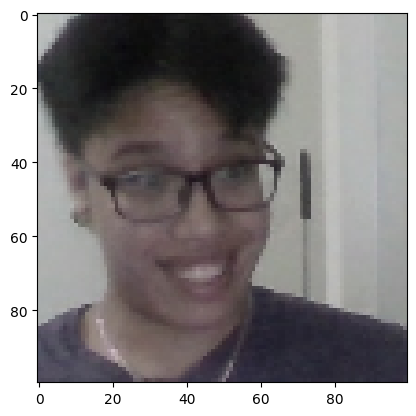

In [18]:
plt.imshow(img)

## 3.3. Create Labelled Dataset

In [19]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
tf.ones(len(anchor))

<tf.Tensor: shape=(3000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
samples = data.as_numpy_iterator()

In [24]:
samples.next()

(b'data\\anchor\\c3d826d9-1e1f-11ef-8148-845cf3d6a57d.jpg',
 b'data\\positive\\cb0f8968-1e1f-11ef-93c8-845cf3d6a57d.jpg',
 1.0)

## 3.4. Build Train and Test Set

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [26]:
example = samples.next()

In [27]:
example

(b'data\\anchor\\8c60c79b-1ed0-11ef-9573-845cf3d6a57d.jpg',
 b'data\\positive\\d055069c-1e1f-11ef-859e-845cf3d6a57d.jpg',
 1.0)

In [28]:
res = preprocess_twin(*example)

In [29]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.6970588 , 0.75980395, 0.7088235 ],
         [0.6911765 , 0.75392157, 0.7029412 ],
         [0.6882353 , 0.7509804 , 0.7       ],
         ...,
         [0.6482843 , 0.71887255, 0.6639706 ],
         [0.6453431 , 0.71593136, 0.6610294 ],
         [0.64705884, 0.7176471 , 0.6627451 ]],
 
        [[0.6960784 , 0.75686276, 0.7058824 ],
         [0.6911765 , 0.7519608 , 0.70098037],
         [0.6882353 , 0.7490196 , 0.69803923],
         ...,
         [0.6522059 , 0.714951  , 0.66593134],
         [0.6512255 , 0.7139706 , 0.66495097],
         [0.654902  , 0.7176471 , 0.66862744]],
 
        [[0.7019608 , 0.75686276, 0.7058824 ],
         [0.7002451 , 0.75514704, 0.70416665],
         [0.69411767, 0.7490196 , 0.69803923],
         ...,
         [0.6627451 , 0.7254902 , 0.6764706 ],
         [0.65906864, 0.72181374, 0.6727941 ],
         [0.65588236, 0.71862745, 0.6696078 ]],
 
        ...,
 
        [[0.50392157, 0.55490196

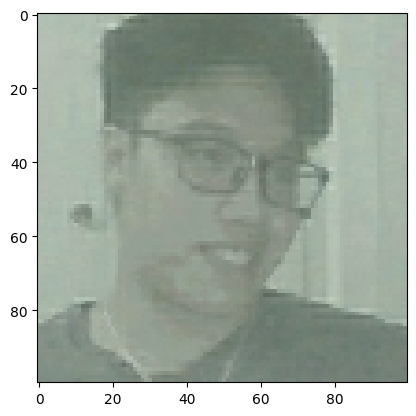

In [30]:
plt.imshow(res[0])

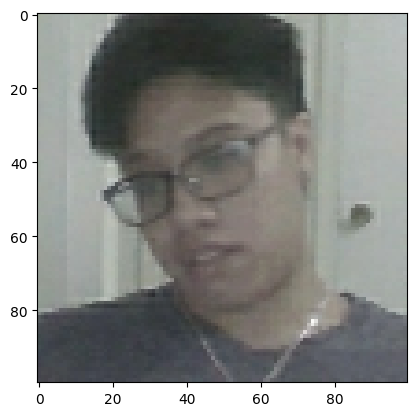

In [31]:
plt.imshow(res[1])

In [32]:
res[2]

1.0

In [33]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [34]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [35]:
samples = data.as_numpy_iterator()

In [36]:
sample = samples.next()

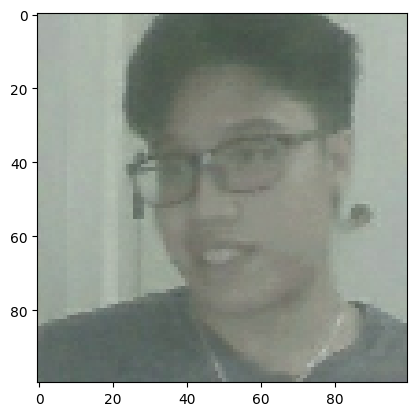

In [37]:
plt.imshow(sample[0])

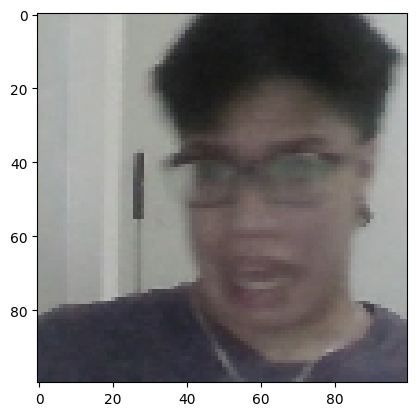

In [38]:
plt.imshow(sample[1])

In [39]:
sample[2]

1.0

In [40]:
# Training set
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [41]:
# Testing set
test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1. Build Embedding Layer

In [42]:
inp = Input(shape=(100,100,3), name='input_image')

In [43]:
inp # None refer to batch size

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [44]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [45]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [46]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [47]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [48]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [49]:
6*6*256

9216

In [50]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [51]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [55]:
embedding = make_embedding()

In [56]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2. Build Distance Layer

In [57]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3. Make Siamese Model

In [58]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [59]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [60]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [61]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [62]:
siamese_layer = L1Dist()

In [63]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [64]:
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [65]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [66]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [67]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [68]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [69]:
siamese_model = make_siamese_model()

In [70]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

#  5. Training

## 5.1. Setup Loss and Optimizer

In [71]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [72]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2. Establish Checkpoints

In [73]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3. Build Train Step Function

In [74]:
test_batch = train_data.as_numpy_iterator()

In [75]:
batch_1 = test_batch.next()

In [76]:
batch_1[0]

array([[[[0.7254902 , 0.75686276, 0.7058824 ],
         [0.7223039 , 0.7536765 , 0.7105392 ],
         [0.7254902 , 0.75392157, 0.71960783],
         ...,
         [0.6598039 , 0.6862745 , 0.6617647 ],
         [0.67058825, 0.69411767, 0.6784314 ],
         [0.654902  , 0.6784314 , 0.6627451 ]],

        [[0.7227941 , 0.75416666, 0.7110294 ],
         [0.71862745, 0.7497549 , 0.70735294],
         [0.71642154, 0.74460787, 0.7110294 ],
         ...,
         [0.65882355, 0.6852941 , 0.6607843 ],
         [0.6610294 , 0.6845588 , 0.66887254],
         [0.654902  , 0.6784314 , 0.6627451 ]],

        [[0.71960783, 0.7480392 , 0.7137255 ],
         [0.7147059 , 0.74289215, 0.70931375],
         [0.7117647 , 0.7392157 , 0.7078431 ],
         ...,
         [0.6610294 , 0.6875    , 0.6629902 ],
         [0.65882355, 0.68235296, 0.6666667 ],
         [0.6578431 , 0.6813725 , 0.66568625]],

        ...,

        [[0.4034314 , 0.44264707, 0.4406863 ],
         [0.40833333, 0.44558823, 0.44460785]

In [77]:
X = batch_1[:2]

In [78]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [79]:
y = batch_1[2]

In [80]:
y

array([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [81]:
@tf.function
def train_step(batch):
    # Record all operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4. Build Training Loop

In [82]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [83]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        # print(loss.numpy(), r.result().numpy(), p.result().numpy())
        print(loss.numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5. Train the model

In [84]:
EPOCHS = 50

In [85]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 153ms/step


263/263 [==============================] - 68s 232ms/step
0.015469905

 Epoch 2/50
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 119ms/step


263/263 [==============================] - 53s 200ms/step
0.016208202

 Epoch 3/50
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 98ms/step


263/263 [==============================] - 50s 191ms/step
0.0028474254

 Epoch 4/50
1/1 [==============================] - 0s 111ms/step


263/263 [==============================] - 48s 184ms/step
0.021747746

 Epoch 5/50
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 105ms/step


263/263 [==============================] - 47s 179ms/step
1.4387491e-05

 Epoch 6/50
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 100ms/step


263/263 [==============================] - 46s 174ms/step
0.00053591136

 Epoch 7/50
1/1 [==============================] - 0s 87ms/step


263/263 [==============================] - 45s 170ms/step
0.026178956

 Epoch 8/50
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 82ms/step


263/263 [==============================] - 44s 168ms/step
0.00016138176

 Epoch 9/50
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 98ms/step


263/263 [==============================] - 44s 168ms/step
0.018913012

 Epoch 10/50
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 103ms/step


263/263 [==============================] - 46s 174ms/step
0.0058814343

 Epoch 11/50
1/1 [==============================] - 0s 113ms/step


263/263 [==============================] - 47s 177ms/step
0.020070707

 Epoch 12/50
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 100ms/step


263/263 [==============================] - 46s 175ms/step
0.044486277

 Epoch 13/50
1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 98ms/step


263/263 [==============================] - 46s 174ms/step
0.023811322

 Epoch 14/50
1/1 [==============================] - 0s 97ms/step


263/263 [==============================] - 46s 174ms/step
0.033307686

 Epoch 15/50
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 102ms/step


263/263 [==============================] - 46s 176ms/step
0.0006322465

 Epoch 16/50
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 90ms/step


263/263 [==============================] - 46s 176ms/step
2.5958805e-05

 Epoch 17/50
1/1 [==============================] - 0s 104ms/step


263/263 [==============================] - 47s 177ms/step
0.00032092351

 Epoch 18/50


1/1 [==============================] - 0s 99ms/step


263/263 [==============================] - 46s 176ms/step
0.00028182057

 Epoch 19/50
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 101ms/step


263/263 [==============================] - 46s 177ms/step
0.0019827392

 Epoch 20/50
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 101ms/step


263/263 [==============================] - 44s 169ms/step
0.00021252017

 Epoch 21/50
1/1 [==============================] - 0s 72ms/step


263/263 [==============================] - 44s 167ms/step
0.022728402

 Epoch 22/50
1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 87ms/step


263/263 [==============================] - 43s 164ms/step
0.00024149017

 Epoch 23/50
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 88ms/step


263/263 [==============================] - 43s 162ms/step
0.0011054489

 Epoch 24/50
1/1 [==============================] - 0s 100ms/step


263/263 [==============================] - 44s 167ms/step
0.0011859869

 Epoch 25/50
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 99ms/step


263/263 [==============================] - 44s 167ms/step
4.2415093e-05

 Epoch 26/50
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 98ms/step


263/263 [==============================] - 44s 167ms/step
0.00015029534

 Epoch 27/50
1/1 [==============================] - 0s 98ms/step


263/263 [==============================] - 44s 167ms/step
0.0009066053

 Epoch 28/50
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


263/263 [==============================] - 43s 165ms/step
2.704568e-06

 Epoch 29/50
1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 93ms/step


263/263 [==============================] - 43s 165ms/step
0.0022438406

 Epoch 30/50
1/1 [==============================] - 0s 91ms/step


263/263 [==============================] - 43s 165ms/step
0.0006394892

 Epoch 31/50
1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 93ms/step


263/263 [==============================] - 43s 165ms/step
0.000101209385

 Epoch 32/50
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 95ms/step


263/263 [==============================] - 44s 166ms/step
0.00013173686

 Epoch 33/50
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 91ms/step


263/263 [==============================] - 44s 169ms/step
3.229198e-05

 Epoch 34/50
1/1 [==============================] - 0s 91ms/step


263/263 [==============================] - 44s 167ms/step
9.368587e-05

 Epoch 35/50
1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 88ms/step


263/263 [==============================] - 44s 168ms/step
0.0003351628

 Epoch 36/50
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


263/263 [==============================] - 44s 168ms/step
4.9768543e-05

 Epoch 37/50
1/1 [==============================] - 0s 91ms/step


263/263 [==============================] - 44s 169ms/step
4.348396e-05

 Epoch 38/50
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 94ms/step


263/263 [==============================] - 44s 168ms/step
8.754722e-05

 Epoch 39/50
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 94ms/step


263/263 [==============================] - 44s 166ms/step
5.6459172e-05

 Epoch 40/50
1/1 [==============================] - 0s 85ms/step


263/263 [==============================] - 43s 165ms/step
1.0200258e-05

 Epoch 41/50
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 99ms/step


263/263 [==============================] - 44s 166ms/step
0.0019745182

 Epoch 42/50
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 93ms/step


263/263 [==============================] - 44s 166ms/step
0.0009483011

 Epoch 43/50
1/1 [==============================] - 0s 90ms/step


263/263 [==============================] - 44s 166ms/step
1.4566704e-05

 Epoch 44/50
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 95ms/step


263/263 [==============================] - 44s 167ms/step
4.2434374e-05

 Epoch 45/50
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 89ms/step


263/263 [==============================] - 44s 167ms/step
2.9655446e-05

 Epoch 46/50
1/1 [==============================] - 0s 104ms/step


263/263 [==============================] - 46s 173ms/step
2.4566361e-05

 Epoch 47/50
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 89ms/step


263/263 [==============================] - 44s 169ms/step
0.0004208251

 Epoch 48/50
1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 106ms/step


263/263 [==============================] - 46s 177ms/step
0.14132711

 Epoch 49/50
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 109ms/step


263/263 [==============================] - 48s 184ms/step
0.028038189

 Epoch 50/50
1/1 [==============================] - 0s 107ms/step


263/263 [==============================] - 49s 185ms/step
0.039675735


# 6. Evaluate Model

## 6.1. Import Metrics

In [86]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2. Make predictions

In [87]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [88]:
test_var = test_data.as_numpy_iterator().next()

In [89]:
test_var[2]

array([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [90]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 27ms/step


array([[0.00113417],
       [0.98273945],
       [0.98769623],
       [0.98503035],
       [0.00845728],
       [0.9922754 ],
       [0.00182893],
       [0.01345459],
       [0.00613364],
       [0.6842343 ],
       [0.7952136 ],
       [0.00115603],
       [0.01642269],
       [0.9994209 ],
       [0.00588188],
       [0.9968838 ]], dtype=float32)

In [91]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [92]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

## 6.3. Calculate Metrics

In [93]:
# Create a metric object
m = Recall()

# Calculate recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [94]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)
    
print(r.result, p.result)

1/1 [==============================] - 0s 16ms/step
<bound method Metric.__new__.<locals>.result_fn of <keras.metrics.metrics.Recall object at 0x000001B33D4E7B50>> <bound method Metric.__new__.<locals>.result_fn of <keras.metrics.metrics.Precision object at 0x000001B34BFD7280>>


## 6.4. Visualize Results

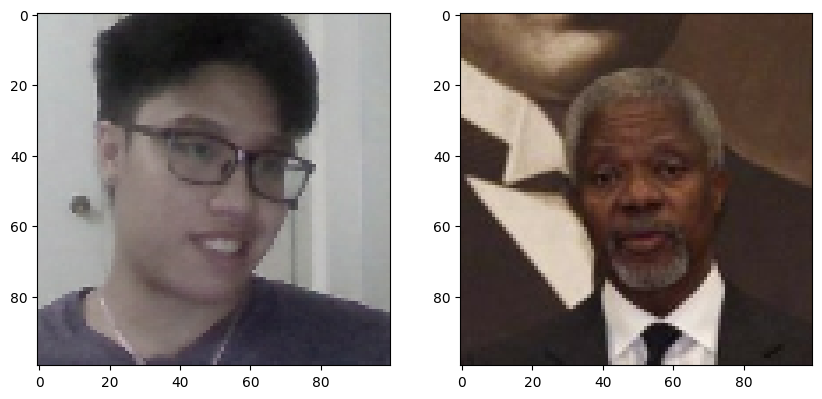

In [95]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

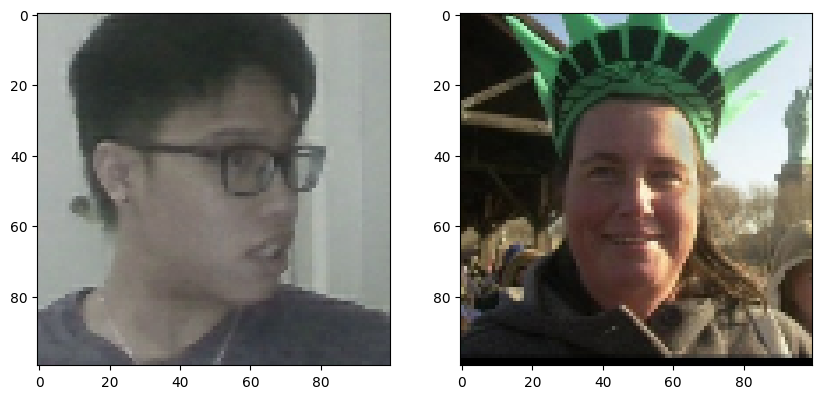

In [96]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

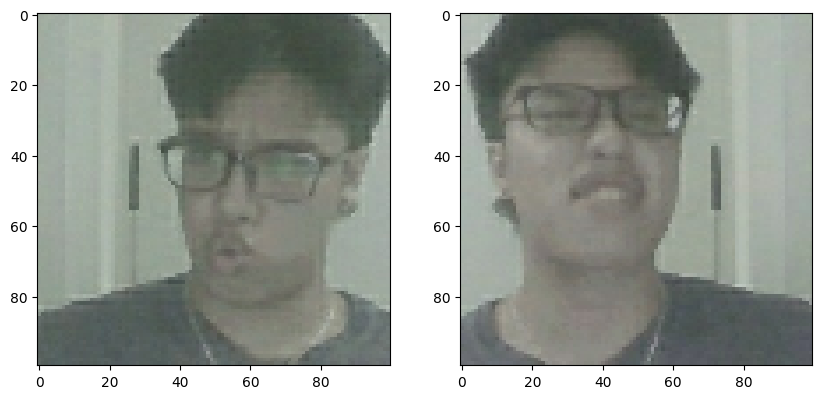

In [97]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# 7. Save Model

In [99]:
# Save weights
# siamese_model.save('siamesemodel.h5')
siamese_model.save('siamesemodelv2.h5')

In [100]:
# Reload model
reloaded_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                           custom_objects={
                                               'L1Dist': L1Dist,
                                               'BinaryCrossentropy': tf.losses.BinaryCrossentropy
                                           })

In [101]:
# Make predictions with reloaded model
reloaded_model.predict([test_input, test_val])

1/1 [==============================] - 0s 101ms/step


array([[0.02368189],
       [0.9726323 ],
       [0.01598642],
       [0.00155674],
       [0.99716705],
       [0.00429978],
       [0.9780368 ],
       [0.9997248 ]], dtype=float32)

In [212]:
# View model summary
reloaded_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 va;idation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'va;idation_image[0

# 8. Real Time Test

## 8.1. Verification Function

In [213]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00c61f8f-1c6d-11ef-a387-845cf3d6a57d.jpg',
 '00f394d3-1c6d-11ef-805a-845cf3d6a57d.jpg',
 '01adc93b-1c6d-11ef-a292-845cf3d6a57d.jpg',
 '02bb927a-1c6d-11ef-82cc-845cf3d6a57d.jpg',
 '0a05bfe4-1c6d-11ef-a886-845cf3d6a57d.jpg',
 '0a2e306c-1c6d-11ef-9928-845cf3d6a57d.jpg',
 '0a88b77e-1c6d-11ef-9e2c-845cf3d6a57d.jpg',
 '0a995ecc-1c6d-11ef-b91a-845cf3d6a57d.jpg',
 '0aa07582-1c6d-11ef-80b2-845cf3d6a57d.jpg',
 '0abb135f-1c6d-11ef-9ee2-845cf3d6a57d.jpg',
 '0ae871cc-1c6d-11ef-ab33-845cf3d6a57d.jpg',
 '0b15f994-1c6d-11ef-a33a-845cf3d6a57d.jpg',
 '0b4d1628-1c6d-11ef-a899-845cf3d6a57d.jpg',
 '0c63ed44-1c6d-11ef-9886-845cf3d6a57d.jpg',
 '0c962c66-1c6d-11ef-bac0-845cf3d6a57d.jpg',
 '0ce6bf12-1c6d-11ef-8b4e-845cf3d6a57d.jpg',
 '0d37c04d-1c6d-11ef-880a-845cf3d6a57d.jpg',
 '0db3846f-1c6d-11ef-a266-845cf3d6a57d.jpg',
 '0dc3e114-1c6d-11ef-9d12-845cf3d6a57d.jpg',
 '0de78843-1c6d-11ef-bcff-845cf3d6a57d.jpg',
 '0e0fa16d-1c6d-11ef-b515-845cf3d6a57d.jpg',
 '0e382732-1c6d-11ef-acdf-845cf3d6a57d.jpg',
 '0e6cb53b

In [214]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
        validation_image = (os.path.join('application_data', 'verification_images', image))
        print(validation_image)

application_data\verification_images\00c61f8f-1c6d-11ef-a387-845cf3d6a57d.jpg
application_data\verification_images\00f394d3-1c6d-11ef-805a-845cf3d6a57d.jpg
application_data\verification_images\01adc93b-1c6d-11ef-a292-845cf3d6a57d.jpg
application_data\verification_images\02bb927a-1c6d-11ef-82cc-845cf3d6a57d.jpg
application_data\verification_images\0a05bfe4-1c6d-11ef-a886-845cf3d6a57d.jpg
application_data\verification_images\0a2e306c-1c6d-11ef-9928-845cf3d6a57d.jpg
application_data\verification_images\0a88b77e-1c6d-11ef-9e2c-845cf3d6a57d.jpg
application_data\verification_images\0a995ecc-1c6d-11ef-b91a-845cf3d6a57d.jpg
application_data\verification_images\0aa07582-1c6d-11ef-80b2-845cf3d6a57d.jpg
application_data\verification_images\0abb135f-1c6d-11ef-9ee2-845cf3d6a57d.jpg
application_data\verification_images\0ae871cc-1c6d-11ef-ab33-845cf3d6a57d.jpg
application_data\verification_images\0b15f994-1c6d-11ef-a33a-845cf3d6a57d.jpg
application_data\verification_images\0b4d1628-1c6d-11ef-a899-845

In [215]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2. OpenCV Real Time Verification

In [216]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(reloaded_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
True
1/1 [==============================] - 0s 15ms/step
True
1/1 [==============================] - 0s 14ms/step
True
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 15ms/step
False
